## Predicting house prices: A regression example

### The Boston Housing Price dataset

In [38]:
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

In [39]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [40]:
train_data.shape

(404, 13)

In [41]:
test_data.shape

(102, 13)

In [42]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

### Preparing the data

**Normalizing the data**

In [43]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

### Building your model

**Model definition**

In [44]:
def build_model():
    
    model = Sequential([
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1)
    ])
    
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    
    return model

**K-fold validation**

In [45]:
k = 4
samples = len(train_data) // k
epochs = 100
scores = []

for i in range(k):
    
    print(f"Processing fold #{i}")
    
    X_val = train_data[i * samples: (i + 1) * samples]
    y_val = train_targets[i * samples: (i + 1) * samples]
    
    X_train = np.concatenate([train_data[:i * samples], train_data[(i + 1) * samples:]], axis=0)
    y_targets = np.concatenate([train_targets[:i * samples], train_targets[(i + 1) * samples:]], axis=0)
    
    model = build_model()
    model.fit(X_train, y_targets, epochs=epochs, batch_size=16, verbose=0)
    
    val_mse, val_mae = model.evaluate(X_val, y_val, verbose=0)
    scores.append(val_mae)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [46]:
scores

[1.8742138147354126, 2.6312172412872314, 2.489549398422241, 2.4401004314422607]

In [47]:
np.mean(scores)

2.3587702214717865

**Saving the validation logs at each fold**

In [48]:
epochs = 500
mae_histories = []

for i in range(k):
    
    print(f"Processing fold #{i}")
    
    X_val = train_data[i * samples: (i + 1) * samples]
    y_val = train_targets[i * samples: (i + 1) * samples]
    
    X_train = np.concatenate([train_data[:i * samples], train_data[(i + 1) * samples:]], axis=0)
    y_targets = np.concatenate([train_targets[:i * samples], train_targets[(i + 1) * samples:]], axis=0)
    
    model = build_model()
    history = model.fit(X_train, y_targets, validation_data=(X_val, y_val), epochs=epochs, batch_size=16, verbose=0)    
    mae_histories.append(history.history["val_mae"])

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


**Building the history of successive mean K-fold validation scores**

In [49]:
average_mae_history = [np.mean([x[i] for x in mae_histories]) for i in range(epochs)]

**Plotting validation scores**

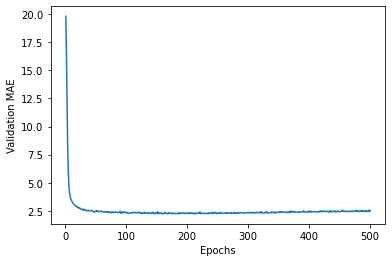

In [50]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Plotting validation scores, excluding the first 10 data points**

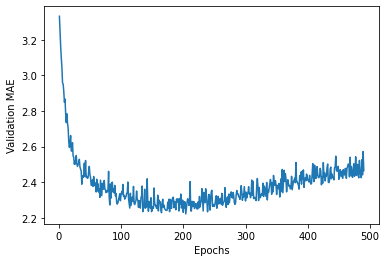

In [51]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

**Training the final model**

In [56]:
model = build_model()
model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 3ms/step - loss: 13.8154 - mae: 2.4297


In [53]:
test_mae_score

2.848695755004883

### Generating predictions on new data

In [54]:
predictions = model.predict(test_data)
predictions[0]

4/4 [==============================] - 0s 1ms/step


array([7.0689387], dtype=float32)